In [1]:
#default_exp lightning.core

In [2]:
#export
from typing import Optional, Callable, Union, Dict
import albumentations as A
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.metrics.functional.classification import accuracy
from pytorch_lightning import _logger as log

from src.core import *
from src.networks import *
from src.mixmethods import *

from hydra.utils import instantiate, call
from omegaconf import OmegaConf, DictConfig

In [3]:
import timm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
#export
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]

In [6]:
def make_show_grid(dl):
    im, batch = next(iter(dl))
    grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(grid);

In [7]:
#export
class CassavaLightningDataModule(pl.LightningDataModule):
    "lightning-datamodule for cassave leaf disease classification"
    def __init__(self, df_path:str, im_dir:str, curr_fold: int,
                 train_augs: A.Compose, valid_augs: A.Compose, bs: int = 64, 
                 num_workers: int=0):
        
        super().__init__()
        self.df = load_dataset(df_path, im_dir, curr_fold, True)
        self.train_augs, self.valid_augs = train_augs, valid_augs
        self.bs, self.workers = bs, num_workers
        self.curr_fold = curr_fold
        self.im_dir = im_dir
    
    def prepare_data(self):
        log.info(f'DATA: {self.im_dir}')
        log.info(f'FOLD: {self.curr_fold}  BATCH_SIZE: {self.bs}')
        self.train_df: pd.DataFrame = self.df.loc[self.df['is_valid'] == False]
        self.valid_df: pd.DataFrame = self.df.loc[self.df['is_valid'] == True]
            
        self.train_df = self.train_df.reset_index(inplace=False, drop=True)
        self.valid_df = self.valid_df.reset_index(inplace=False, drop=True)
            
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_ds = ImageClassificationFromDf(self.train_df, self.train_augs)
            self.valid_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)
        if stage == "test" or stage is None:
            self.test_ds  = ImageClassificationFromDf(self.valid_df, self.valid_augs)
            
    def train_dataloader(self):
        return DataLoader(self.train_ds, shuffle=True, batch_size=self.bs, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.bs, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs, num_workers=self.workers)

DATA: ../../Datasets/cassava/train_images/
FOLD: 0  BATCH_SIZE: 32


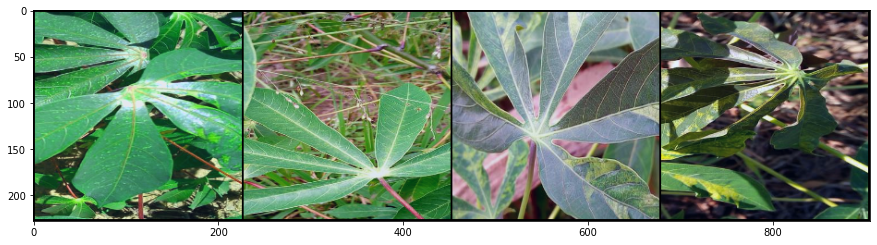

In [8]:
train_augs = A.Compose([
    A.RandomResizedCrop(224, 224, p=1.0),
    A.RandomBrightness(limit=0.1),
    A.HueSaturationValue(20, 20, 20),
    A.HorizontalFlip(),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

valid_augs = A.Compose([
    A.Resize(224, 224, p=1.0),
    A.Normalize(p=1.0),
    ToTensorV2(p=1.0)])

csv = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
ims = "../../Datasets/cassava/train_images/"
dm = CassavaLightningDataModule(csv, ims, curr_fold=0, train_augs=train_augs, 
                                valid_augs=valid_augs, bs=32, num_workers=0)
dm.prepare_data()
dm.setup()
train_dl,valid_dl,test_dl = dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader()
make_show_grid(train_dl)

In [9]:
#export

#TODO: add midlevel classification branch in learning.
class LightningCassava(pl.LightningModule):
    """LightningModule wrapper for `TransferLearningModel`"""
    def __init__(self, 
                 model: Union[TransferLearningModel, SnapMixTransferLearningModel, SnapMixTransferLearningModelBasic], 
                 conf : Union[DictConfig, Dict]):
        
        super().__init__()
        self.model = model
    
        # save hyper-parameters
        self.save_hyperparameters(conf)
        
        try    : 
            mixmethod = instantiate(self.hparams["mixmethod"])
        except : 
            mixmethod = None
            
        if mixmethod is not None:
            if isinstance(mixmethod, SnapMix):
                crit = (isinstance(self.model, SnapMixTransferLearningModel) or 
                        isinstance(self.model, SnapMixTransferLearningModelBasic))
                assert crit
        
            
        self.mix_fn = mixmethod
        self.loss_func = instantiate(self.hparams["loss_function"])
        
        if self.mix_fn is not None:
            log.info(f'Mixmethod : {self.mix_fn.__class__.__name__}')
        
        log.info(f'Loss Function : {self.loss_func}')
        
        self.val_labels_list = []
        self.val_preds_list  = []
        self.one_batch_of_image = None
        
        self.accuracy = pl.metrics.Accuracy()
        
    def forward(self, xb):  
        return self.model(xb)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        if self.mix_fn is not None:
            x = self.mix_fn(x, y, self.model)
            y_hat = self(x)
            loss  = self.mix_fn.loss(self.loss_func, y_hat)
        
        else:
            y_hat = self(x)
            loss  = self.loss_func(y_hat, y)
        
        self.one_batch_of_image = x
            
        train_acc = self.accuracy(y_hat, y)
            
        self.log('train/loss', loss, on_epoch=True)
        self.log('train/acc',  train_acc, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y  = batch
        y_hat = self(x)
        loss  = self.loss_func(y_hat, y)
        acc   = self.accuracy(y_hat, y)
        
        # For confusion matrix purposes
        preds = torch.argmax(y_hat, 1)
        val_labels = y.data.cpu().numpy()
        val_preds = preds.data.cpu().numpy()
        self.val_preds_list = self.val_preds_list + list(val_preds)
        self.val_labels_list = self.val_labels_list + list(val_labels)
        
        metrics = {'valid/loss': loss, 'valid/acc': acc}
        
        self.log_dict(metrics, prog_bar=True, logger=True,)
    
    def test_step(self, batch, batch_idx):
        x, y  = batch
        y_hat = self(x)
        loss  = self.loss_func(y_hat, y)
        acc   = self.accuracy(y_hat, y)
        
        metrics = {'test/loss': loss, 'test/acc': acc}
        self.log_dict(metrics, on_step=False, on_epoch=True, logger=True)
        
    def configure_optimizers(self):
        base_lr = self.hparams["learning_rate"]
        
        param_list = [
            {'params': self.param_list[0], 'lr': base_lr/self.hparams["lr_mult"]},
            {'params': self.param_list[1], 'lr': base_lr}
        ]
        
        opt = instantiate(self.hparams["optimizer"], params=param_list)
        
        if self.hparams["scheduler"] is not None:
            
            if self.hparams["scheduler"]["_target_"] == "torch.optim.lr_scheduler.OneCycleLR":
                lr_list = [base_lr/self.hparams["lr_mult"], base_lr]
                kwargs = dict(optimizer=opt, max_lr=lr_list, steps_per_epoch=len(self.train_dataloader()))
                sch = instantiate(self.hparams["scheduler"], **kwargs)
            
            elif self.hparams["scheduler"]["_target_"] == "src.opts.FlatCos":
                sch = instantiate(self.hparams["scheduler"], 
                                       optimizer=opt, 
                                       steps_per_epoch=len(self.train_dataloader()))
            
            else:
                sch = instantiate(self.hparams["scheduler"], optimizer=opt)
                
            # convert scheduler to lightning format
            sch = {'scheduler': sch, 
                   'monitor'  : self.hparams['metric_to_track'], 
                   'interval' : self.hparams['step_after'], 
                   'frequency': self.hparams['frequency']}
            
            log.info(f"Optimizer: {opt.__class__.__name__}  LR's: {(base_lr/self.hparams['lr_mult'], base_lr)}")
            log.info(f"LR Scheculer: {sch['scheduler'].__class__.__name__}")
            return [opt], [sch]
        
        else:
            log.info(f"Optimizer: {opt.__class__.__name__}")
            return [opt]
        
    @property
    def param_list(self):
        if isinstance(self.model, SnapMixTransferLearningModel):
            param_list = [params(self.model.encoder), params(self.model.fc)+params(self.model.ls)]
        else:
            param_list = [params(self.model.encoder), params(self.model.fc)]
        return param_list
    
    def save_model_weights(self, path:str):
        state = self.model.state_dict()
        torch.save(state, path)
        log.info(f'weights saved to {path}')
        
    def load_model_weights(self, path:str):
        state_dict = torch.load(path)
        self.model.load_state_dict(state_dict)
        log.info(f'weights loaded from {path}')

In [14]:
model_hparams = dict(
    mixmethod = dict(_target_='src.mixmethods.SnapMix', alpha=5.0, conf_prob=1.0),
    loss_function = dict(_target_='src.core.LabelSmoothingCrossEntropy', eps=0.1),
    learning_rate = 1e-03,
    lr_mult = 100,
    optimizer = dict(_target_='src.opts.Ranger', weight_decay=1e-02, betas=(0.95, 0.999), eps=1e-05),
    scheduler = dict(_target_='torch.optim.lr_scheduler.OneCycleLR', cycle_momentum=True, epochs=10, pct_start=0.3),
    metric_to_track = None,
    step_after = "epoch",
    frequency = 1,
)

cfg = OmegaConf.create(model_hparams)
print(OmegaConf.to_yaml(cfg))

mixmethod:
  _target_: src.mixmethods.SnapMix
  alpha: 5.0
  conf_prob: 1.0
loss_function:
  _target_: src.core.LabelSmoothingCrossEntropy
  eps: 0.1
learning_rate: 0.001
lr_mult: 100
optimizer:
  _target_: src.opts.Ranger
  weight_decay: 0.01
  betas:
  - 0.95
  - 0.999
  eps: 1.0e-05
scheduler:
  _target_: torch.optim.lr_scheduler.OneCycleLR
  cycle_momentum: true
  epochs: 10
  pct_start: 0.3
metric_to_track: null
step_after: epoch
frequency: 1



In [15]:
def train_dataloader(self): return train_dl
LightningCassava.train_dataloader = train_dataloader

encoder = timm.create_model('resnet18', pretrained=False)

model = SnapMixTransferLearningModelBasic(encoder, cut=-2, c=5, act=nn.ReLU(inplace=True))

model = LightningCassava(model=model, conf=cfg)

opt_list, lr_scheduler_list = model.configure_optimizers()
opt, lr_scheduler = opt_list[0], lr_scheduler_list[0]['scheduler']
opt, lr_scheduler

Mixmethod : SnapMix
Loss Function : LabelSmoothingCrossEntropy()
Optimizer: Ranger  LR's: (1e-05, 0.001)
LR Scheculer: OneCycleLR


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


(Ranger (
 Parameter Group 0
     N_sma_threshhold: 5
     alpha: 0.5
     base_momentum: 0.85
     betas: (0.95, 0.999)
     eps: 1e-05
     initial_lr: 4.0000000000000003e-07
     k: 6
     lr: 3.9999999999999956e-07
     max_lr: 1e-05
     max_momentum: 0.95
     min_lr: 4.0000000000000004e-11
     step_counter: 0
     weight_decay: 0.01
 
 Parameter Group 1
     N_sma_threshhold: 5
     alpha: 0.5
     base_momentum: 0.85
     betas: (0.95, 0.999)
     eps: 1e-05
     initial_lr: 4e-05
     k: 6
     lr: 3.9999999999999996e-05
     max_lr: 0.001
     max_momentum: 0.95
     min_lr: 4e-09
     step_counter: 0
     weight_decay: 0.01
 ),
 <torch.optim.lr_scheduler.OneCycleLR at 0x7fbad54e4050>)

In [16]:
print(model.hparams.pretty())

mixmethod:
  _target_: src.mixmethods.SnapMix
  alpha: 5.0
  conf_prob: 1.0
loss_function:
  _target_: src.core.LabelSmoothingCrossEntropy
  eps: 0.1
learning_rate: 0.001
lr_mult: 100
optimizer:
  _target_: src.opts.Ranger
  weight_decay: 0.01
  betas:
  - 0.95
  - 0.999
  eps: 1.0e-05
scheduler:
  _target_: torch.optim.lr_scheduler.OneCycleLR
  cycle_momentum: true
  epochs: 10
  pct_start: 0.3
metric_to_track: null
step_after: epoch
frequency: 1



In [17]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 00a_lightning.core.ipynb.
Converted 00b_fastai.core.ipynb.
Converted 01_mixmethods.ipynb.
Converted 01b_lightning.callbacks.ipynb.
Converted 02_layers.ipynb.
Converted 02a_networks.ipynb.
Converted 03_optimizers.ipynb.
Converted index.ipynb.
